In [1]:
import pandas as pd
import json,csv,re,os,sys,glob,dateutil,collections,operator,time,traceback
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mpld3
# mpl.rcParams['axes.titlesize'] = 18
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['legend.fontsize'] = 12
%matplotlib inline

In [2]:
import sys
sys.path.append('/mnt/home/ubuntu/projects/tools/')
from gp_colours import *

In [3]:
# Get emojis
stem=''
posEmojiFile=csv.reader(open(stem+'pos_emojis.txt','r'),delimiter='\t')
posEmojiFileUnicode=csv.reader(open(stem+'pos_emojis_unicode.txt','r'),delimiter='\t')
posEmojiSymbols=[line[0].decode('utf-8') for line in posEmojiFile if len(line)>0]
posEmojiSymbols+=[line[0].decode('utf-8') for line in posEmojiFileUnicode if len(line)>0]
posEmojiSymbols=[e.replace('(','\(').replace(')','\)').replace('.','\.').replace('|','\|').replace("'","\'") for e in posEmojiSymbols]

negEmojiFile=csv.reader(open(stem+'neg_emojis.txt','r'),delimiter='\t')
negEmojiFileUnicode=csv.reader(open(stem+'neg_emojis_unicode.txt','r'),delimiter='\t')
negEmojiSymbols=[line[0].decode('utf-8') for line in negEmojiFile if len(line)>0]
negEmojiSymbols+=[line[0].decode('utf-8') for line in negEmojiFileUnicode if len(line)>0]
negEmojiSymbols=[e.replace('(','\(').replace(')','\)').replace('.','\.').replace('|','\|').replace("'","\'").replace(":","\:").replace("[","\[").replace("]","\]") for e in negEmojiSymbols]

In [4]:
#plotColours=[gpBlue,gpDarkBlue,gpRed,'black']
#plotColours=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff53','#a65628','#f781bf','#9999f9']
plotColours=['#1B6E44','#6D1431','#FF5500','#5D6263','#009D97','#c84699','#71be45','#3F8CBC','#FFC200']
plotColours.extend(plotColours)
def colours():
    n=0
    for c in plotColours:
        yield c
    # Give me a new colour, one at a time
coloursClass=colours()
# We need a whole bunch of colours, so repeat them

In [ ]:
!python count_stuff_RCN.py;

In [6]:
dateList;

In [8]:
reducedSeriesPos=None
reducedSeriesNeg=None
reducedSeriesNet=None
reducedSeriesTotal=None
reducedSeriesPosEmojis=None
reducedSeriesNegEmojis=None

totalSeriesPositive=None
totalSeriesNegative=None
totalSeriesNet=None
totalSeriesTotal=None
totalSeriesPosEmojis=None
totalSeriesNegEmojis=None
# Keep hourly/daily series sentiments

sentimentCounter=collections.defaultdict(int)

sentimentHist=np.zeros(shape=(41,len(dateList)))

accountCounter=collections.defaultdict(int)

nError=0
nTotal=0

for dir in glob.glob('../data/2014-0[0-9]'):
    print dir
    for f in glob.glob(dir+'/Data*json'):

        times=[]
        positives=[]
        negatives=[]
        posEmojis=[]
        negEmojis=[]
        net=[]
        totals=[]
        # Keep times and sentiment in memory 
        # Only one file at a time
        
        for newline in open(f,'r').read().decode('utf-8').split('\n'):
            tweet=json.loads(newline)
            
            nTotal+=1
            
            try:

                accountCounter[tweet['interaction']['author']['username']]+=1
                
                timeCreated=dateutil.parser.parse(tweet['interaction']['created_at'])
                tweetContent=tweet['interaction']['content'].encode('utf-8')
                sentiment=tweet['interaction']['tag_tree']['sentiment'].keys()[0]
                sentimentValue=int(tweet['interaction']['tag_tree']['sentiment'].values()[0][0])
                times.append(timeCreated)
                totals.append(1)
                net.append(sentimentValue)
                
                sentimentCounter[sentimentValue]+=1
                sentimentHist[sentimentValue+20][dateList.index(timeCreated.date())]+=1
                

                '''
                if re.search(r':-\)|:\)',tweetContent):
                    posEmojis.append(1)
                else:
                    posEmojis.append(0)
                if re.search(r':-\(|:\(',tweetContent):
                    negEmojis.append(1)
                else:
                    negEmojis.append(0)
                '''
                negEmojis.append(0)
                posEmojis.append(0)
                
                
                if sentiment=='Positive':
                    positives.append(1)
#                    positives.append(sentimentValue)
                    negatives.append(np.nan)
                elif sentiment=='Negative':
                    positives.append(np.nan)
                    negatives.append(1)
#                    negatives.append(-1.0*sentimentValue)
                elif sentiment=='Neutral':
                    positives.append(0)
                    negatives.append(0)   

                    
            except:
#                print traceback.print_exc()
#                time.sleep(100)
                nError+=1            
#        for t,p in zip(times,positives):
#            print t,p
#        time.sleep(10000)    
        tempDf=pd.DataFrame(data={'positive':positives,'negative':negatives,'total':totals,'net':net,'posEmojis':posEmojis,'negEmojis':negEmojis},index=times)
        # Make a dataframe with contents of this file    
        
        if not type(totalSeriesPositive)==pd.Series:
            totalSeriesPositive=tempDf.resample('D',how='sum')['positive']
            totalSeriesNegative=tempDf.resample('D',how='sum')['negative']
            totalSeriesPosEmojis=tempDf.resample('D',how='mean')['posEmojis']
            totalSeriesNegEmojis=tempDf.resample('D',how='mean')['negEmojis']
            totalSeriesNet=tempDf.resample('D',how='mean')['net']
            totalSeriesTotal=tempDf.resample('D',how='sum')['total']

#            print totalSeriesNegative
#            time.sleep(100)
            # First time through, add downsampled series
        else:
            totalSeriesPositive=totalSeriesPositive.add(tempDf.resample('D',how='sum')['positive'],fill_value=0)
            totalSeriesNegative=totalSeriesNegative.add(tempDf.resample('D',how='sum')['negative'],fill_value=0)
            totalSeriesPosEmojis=totalSeriesPosEmojis.add(tempDf.resample('D',how='sum')['posEmojis'],fill_value=0)
            totalSeriesNegEmojis=totalSeriesNegEmojis.add(tempDf.resample('D',how='sum')['negEmojis'],fill_value=0)
            totalSeriesNet=totalSeriesNet.add(tempDf.resample('D',how='mean')['net'],fill_value=0)
            totalSeriesTotal=totalSeriesTotal.add(tempDf.resample('D',how='sum')['total'],fill_value=0)

    print 'ERRORS',nError,'TOTAL',nTotal

../data/2014-08
ERRORS 43117 TOTAL 1021570
../data/2014-05
ERRORS 96758 TOTAL 3458126
../data/2014-07
ERRORS 142937 TOTAL 5439086
../data/2014-04
ERRORS 193210 TOTAL 7339607
../data/2014-06
ERRORS 248595 TOTAL 9634034


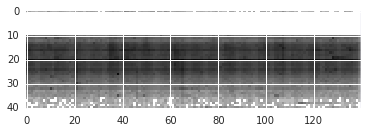

In [31]:
plt.imshow(np.log(sentimentHist+0.001),interpolation='none')
#plt.colorbar()

In [ ]:
for n in range(40):print n-20,np.max(sentimentHist[n])

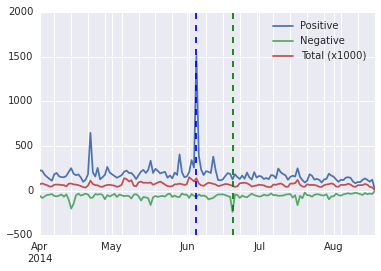

In [24]:
totalSeriesPosEmojis.plot(label='Positive',legend=True)
(-1.0*totalSeriesNegEmojis).plot(label='Negative',legend=True)
(totalSeriesTotal/1000.0).plot(label='Total (x1000)',legend=True)
plt.axvline(totalSeriesPosEmojis.idxmax(),linestyle='--',color='b')
plt.axvline(totalSeriesNegEmojis.idxmax(),linestyle='--',color='g')
plt.savefig('../web/charts/PLOT_Sentiment.png',dpi=60)

In [34]:
print totalSeriesPosEmojis.idxmax() # Most positive emojis day
print totalSeriesNegEmojis.idxmax() # Most negative emojis day

2014-06-05 00:00:00+00:00
2014-07-17 00:00:00+00:00


In [15]:
totalSeriesNegEmojisNorm=(totalSeriesNegEmojis-totalSeriesNegEmojis.mean())/totalSeriesNegEmojis.std()
totalSeriesPosEmojisNorm=(totalSeriesPosEmojis-totalSeriesPosEmojis.mean())/totalSeriesPosEmojis.std()

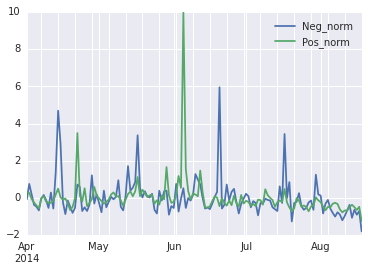

In [16]:
(totalSeriesNegEmojisNorm).plot(label='Neg_norm',legend=True)
(totalSeriesPosEmojisNorm).plot(label='Pos_norm',legend=True)

In [20]:
# 22/4 Earth Day
# 5/6 World Environment Day
# ----------------
# 14/4 climate report https://twitter.com/Independent/status/455612789805944832/photo/1
# 17/5 Arsenal trophy drought jokes
# 20/6 Bit unclear
# 17/7 Australia repeals carbon tax law

In [19]:
print totalSeriesPosEmojisNorm[totalSeriesPosEmojisNorm.abs()>2]
print '-------------'
print totalSeriesNegEmojisNorm[totalSeriesNegEmojisNorm.abs()>2]

2014-04-22 00:00:00+00:00    3.487707
2014-06-05 00:00:00+00:00    9.979398
Name: posEmojis, dtype: float64
-------------
2014-04-14 00:00:00+00:00    4.695662
2014-04-15 00:00:00+00:00    2.908280
2014-05-17 00:00:00+00:00    3.371675
2014-06-20 00:00:00+00:00    5.953450
2014-07-17 00:00:00+00:00    3.437875
Name: negEmojis, dtype: float64


In [36]:
print totalSeriesPosEmojis[totalSeriesPosEmojis>80]

2014-04-22 00:00:00+00:00     92
2014-06-05 00:00:00+00:00    220
2014-07-09 00:00:00+00:00    110
Name: posEmojis, dtype: float64


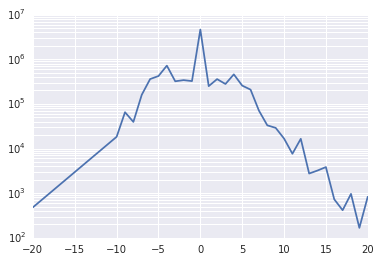

In [33]:
#for k,v in sorted(sentimentCounter.iteritems(),key=lambda x:x[0]):
#    print k,v
plt.semilogy([k for k,v in sorted(sentimentCounter.iteritems(),key=lambda x:x[0])],[v for k,v in sorted(sentimentCounter.iteritems(),key=lambda x:x[0])])
plt.savefig('dist.png',dpi=400)

In [17]:
print totalSeriesPositive.idxmax() # Most number positive day
print totalSeriesNegative.idxmax() # Most number negative day
print totalSeriesTotal.idxmax() # Most everything day
print totalSeriesNet.idxmax() # Most overall positive day
print totalSeriesNet.idxmin() # Most overall negative day

2014-05-09 00:00:00+00:00
2014-06-01 00:00:00+00:00
2014-06-02 00:00:00+00:00
2014-05-09 00:00:00+00:00
2014-07-17 00:00:00+00:00


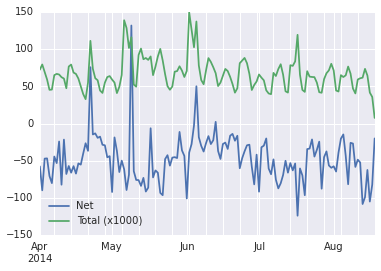

In [37]:
totalSeriesNet.plot(label='Net',legend=True)
(totalSeriesTotal/1000).plot(label='Total (x1000)',legend=True)
plt.savefig('net_sentiment.png',dpi=400)

In [39]:
totalSeriesNet[totalSeriesNet>50]
# Where series goes above 50

2014-04-22 00:00:00+00:00     75.793149
2014-05-09 00:00:00+00:00    131.821266
2014-06-05 00:00:00+00:00     50.144493
Name: net, dtype: float64

In [42]:
totalSeriesNet[totalSeriesNet<-100]
# Where series goes below 80

2014-06-01 00:00:00+00:00   -100.572141
2014-07-17 00:00:00+00:00   -123.777172
2014-08-13 00:00:00+00:00   -108.087762
2014-08-16 00:00:00+00:00   -104.795145
Name: net, dtype: float64

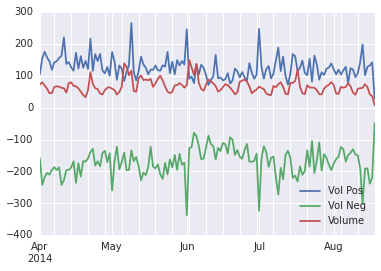

In [32]:
totalSeriesPositive.plot(label='Vol Pos',legend=True)
(-1.0*totalSeriesNegative).plot(label='Vol Neg',legend=True)
(totalSeriesTotal/1000.0).plot(label='Volume',legend=True)
plt.savefig('number.png',dpi=400)

In [5]:
import pickle
if False:    
    dumpFile=open('DUMP_sentiments.dat','w')
    pickle.dump(totalSeriesPositive,dumpFile)
    pickle.dump(totalSeriesNegative,dumpFile)
    pickle.dump(totalSeriesTotal,dumpFile)
    pickle.dump(totalSeriesNet,dumpFile)
    pickle.dump(totalSeriesPosEmojis,dumpFile)
    pickle.dump(totalSeriesNegEmojis,dumpFile)
    pickle.dump(sentimentCounter,dumpFile)
    pickle.dump(dateList,dumpFile)
    pickle.dump(sentimentHist,dumpFile)
else:
    dumpFile=open('DUMP_sentiments.dat','r')
    totalSeriesPositive=pickle.load(dumpFile)
    totalSeriesNegative=pickle.load(dumpFile)
    totalSeriesTotal=pickle.load(dumpFile)
    totalSeriesNet=pickle.load(dumpFile)
    totalSeriesPosEmojis=pickle.load(dumpFile)
    totalSeriesNegEmojis=pickle.load(dumpFile)
    sentimentCounter=pickle.load(dumpFile)
    dateList=pickle.load(dumpFile)
    sentimentHist=pickle.load(dumpFile)
dumpFile.close()
    

In [9]:
    dumpFile=open('DUMP_accounts.dat','accountCounaccountCounaccaccaccaccountCounter
    pickle.dump(accountCounter,dumpFile)
    dumpFile.close()

In [1]:
from IPython.core.display import HTML
styles = open("../css/custom.css", "r").read()
HTML(styles)